### 目的
二酸化炭素濃度の経年変化に時系列解析（SARIMA）を適用し、最近2年間の濃度変化を予測する。
データは[こちら](https://www.data.jma.go.jp/ghg/kanshi/obs/co2_monthave_ryo.html)からダウンロードした。気象庁が提供するデータである。


In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

ダウンロードしたデータに対し以下の変更を行った。
- 2011年4月のデータが欠損しているので、2011年3月と5月の値の平均値を割り振った。
- 日付の年と月が別々の列に分かれていたのでこれら統合した。統合後の例：1987-12

以下のパスSRC_PATHは変更後のファイルである。

In [2]:
SRC_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/data/co2_monthave_ryo_concated.csv'

# Load the CSV file
data = pd.read_csv(SRC_PATH)

# Convert the 'date' column to a datetime format for better plotting
data["date"] = pd.to_datetime(data["date"], infer_datetime_format=True)

### 元データの観察

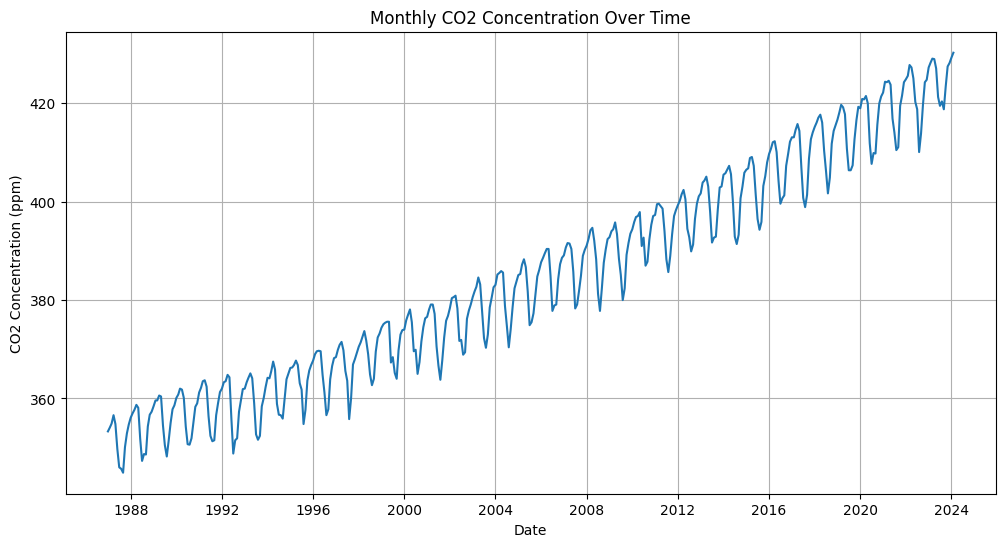

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
plt.grid(True)
SRC_GRAPH_1_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_1.jpg'
plt.savefig(SRC_GRAPH_1_PATH)


- 右肩上がりである。つまり単調に増加するというトレンドがある。
- 1年周期を持つ。

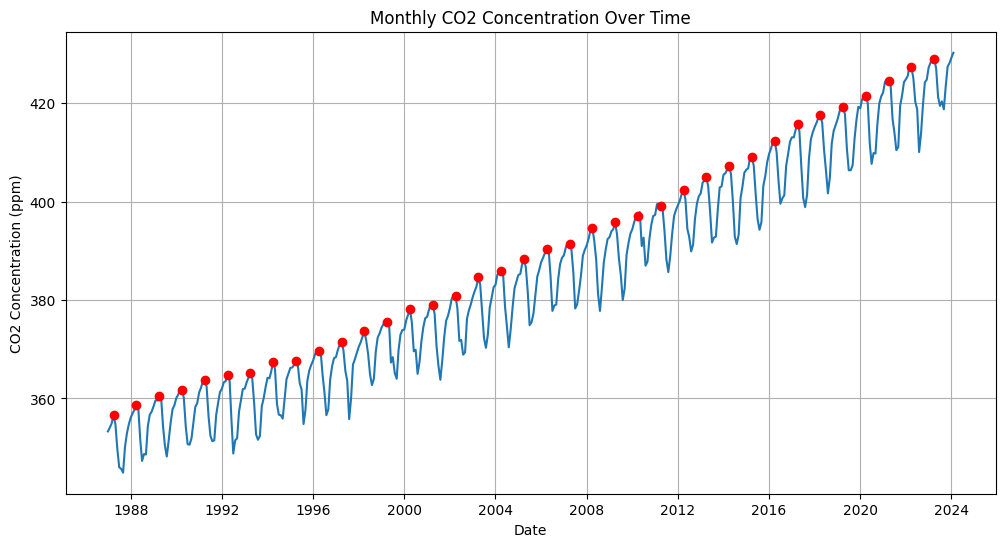

In [4]:
# Extract only the rows corresponding to April for drawing vertical lines
april_dates = data[data['date'].dt.month == 4]['date']

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates
plt.plot(april_dates, data[data['date'].dt.month == 4]['co2'], 'o', color='red')
plt.grid(True)
SRC_GRAPH_2_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_2.jpg'
plt.savefig(SRC_GRAPH_2_PATH)


- 4月に極大値がある（赤丸）。

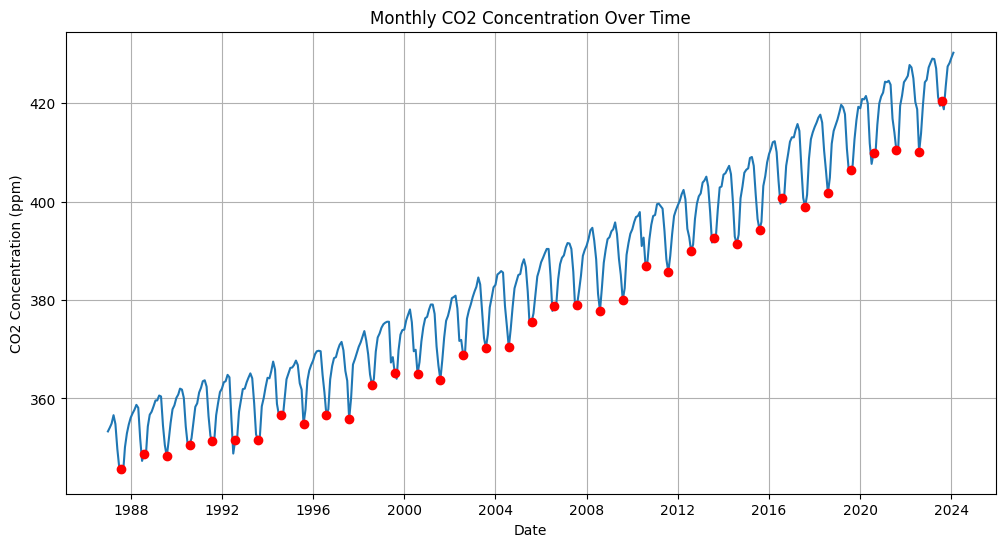

In [5]:
aug_dates = data[data['date'].dt.month == 8]['date']
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates
plt.plot(aug_dates, data[data['date'].dt.month == 8]['co2'], 'o', color='red')
plt.grid(True)
SRC_GRAPH_4_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_4.jpg'
plt.savefig(SRC_GRAPH_4_PATH)


- 8月に極小値がある（赤丸）。

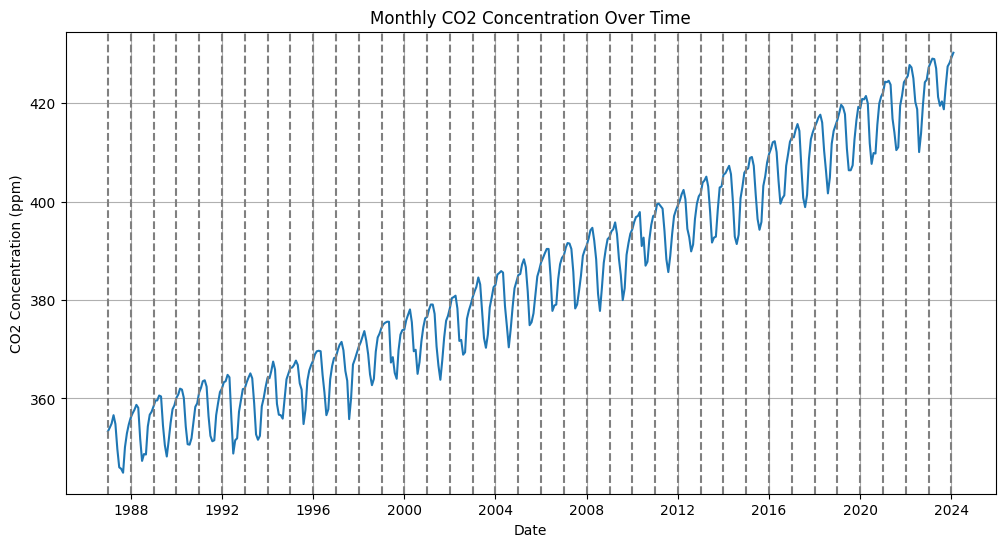

In [7]:
# Extract only the rows corresponding to April for drawing vertical lines
jan_dates = data[data['date'].dt.month == 1]['date']

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["co2"]) # , marker="o")
plt.title("Monthly CO2 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")
# Add markers only at April dates

# Add vertical dashed lines at every April
for jan_date in jan_dates:
    plt.axvline(x=jan_date, color='gray', linestyle='--')

plt.grid(True)
SRC_GRAPH_3_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/src_graph_3.jpg'
plt.savefig(SRC_GRAPH_3_PATH)


- 垂直な点線間は1年を示す。つまり季節的な周期がある。

### 時系列分解

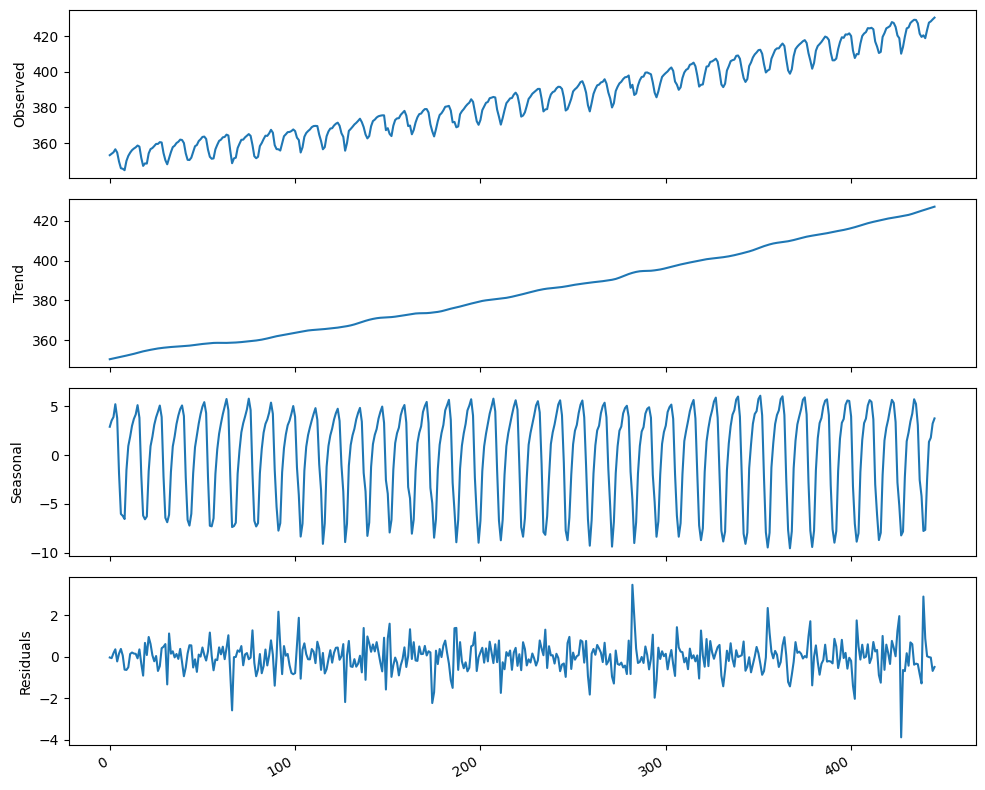

In [8]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(data['co2'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

#plt.xticks(np.arange(0, 447, 12), np.arange(1988, 2024, 1))

fig.autofmt_xdate()
plt.tight_layout()

DECOM_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/images/decomposition.jpg'
plt.savefig(DECOM_PATH, dpi=300)

上のグラフから以下を読み取れる。
- 単調増加するトレンドがある。
- 年周期の変動がある。
- これらを取り除いた残差は無相関（ホワイトノイズ）に見える。

### ARIMAモデルによる予測

In [9]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(data['co2'])
criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: 2.3490677243905096
p-value: 0.9989842880293069
critical 1%: -3.445613745346461
critical 5%: -2.868269325317112
critical 10%: -2.5703544951308404


上の結果より
- ADF統計量がどの臨界値より大きい。
- p値が0.05より大きい。

従って、時系列そのものは定常ではない。次に1次差分を取る。

In [10]:
df_diff = np.diff(data['co2'], n=1)

ad_fuller_result = adfuller(df_diff)

criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: -7.044837391957347
p-value: 5.722230484233865e-10
critical 1%: -3.445613745346461
critical 5%: -2.868269325317112
critical 10%: -2.5703544951308404


- ADF統計量が臨界値よりも小さい。
- p値が0.05より小さい。

上の結果から1次差分は定常に見える。$(D,d)=(0,1)$として$(p,q)$の値を探す。

In [11]:
from itertools import product
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps =[0]
Qs =[0]
d = 1
D = 0
s = 12
Arima_order_list = list(product(ps, qs, Ps, Qs))


In [12]:
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in order_list:
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic # type:ignore
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
# 訓練データとテストデータに分ける。
OFFSET = 24
train = data['co2'][:-OFFSET]
test = data.iloc[-OFFSET:]

In [14]:
ARIMA_result_df = optimize_SARIMA(train, Arima_order_list, d, D, s)
ARIMA_result_df

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

,"(p,q,P,Q)",AIC
0,"(6, 5, 0, 0)",24.000000
1,"(12, 9, 0, 0)",1380.427053
2,"(12, 8, 0, 0)",1392.120992
3,"(11, 12, 0, 0)",1392.745658
4,"(12, 10, 0, 0)",1397.269710
...,...,...
163,"(0, 2, 0, 0)",2054.003616
164,"(1, 1, 0, 0)",2058.011852
165,"(1, 0, 0, 0)",2063.810706
166,"(0, 1, 0, 0)",2069.193529


最適な値は次の通り。
$(p,d,q)=(6,1,5)$

In [15]:
(p, q) = (6, 5)
ARIMA_model = SARIMAX(train, order=(p, d, q), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary()) # type:ignore
# 以下はエラーを出力する。
#ARIMA_model_fit.plot_diagnostics(figsize=(10, 8)) # type: ignore

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  422
Model:               SARIMAX(6, 1, 5)   Log Likelihood                   0.000
Date:                Thu, 29 Aug 2024   AIC                             24.000
Time:                        13:58:43   BIC                             72.512
Sample:                             0   HQIC                            43.172
                                - 422                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1133   4.29e-09   2.64e+07      0.000       0.113       0.113
ar.L2          2.7716   1.23e-07   2.25e+07      0.000       2.772       2.772
ar.L3          0.0010    2.4e-11   4.22e+07      0.0

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# 以下はエラーを出力する。
#ARIMA_model_fit.plot_diagnostics(figsize=(10, 8)) # type: ignore

リュング・ボックス検定

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid # type: ignore
result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,419.078219,3.873320e-93
2,833.024914,1.291036e-181
3,1241.854458,6.082127e-269
4,1645.592199,0.000000e+00
5,2044.249917,0.000000e+00
6,2437.860859,0.000000e+00
7,2826.433220,0.000000e+00
8,3209.985840,0.000000e+00
9,3588.527253,0.000000e+00
10,3962.072522,0.000000e+00


全てのp値が0.05より小さいので、残差に相関がある。つまり、残差をホワイトノイズで近似できない。ARIMA(6,1,5)ではこのデータを表現できないということである。

次に2次差分を試す。

In [18]:
df_diff2 = np.diff(data['co2'], n=2)
ad_fuller_result = adfuller(df_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore


ADF Statistic: -11.228968392977693
p-value: 1.9287138410536416e-20
critical 1%: -3.445613745346461
critical 5%: -2.868269325317112
critical 10%: -2.5703544951308404


- ADF統計量は臨界値より小さい。
- p値は0.05より小さい。

よって、差分は定常となる。
$(d,D)=(2,0)$として$(p,q)$の値を探す。

In [19]:
from itertools import product
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps =[0]
Qs =[0]
d = 2
D = 0
s = 12
Arima_order_list = list(product(ps, qs, Ps, Qs))


In [20]:
ARIMA_result_df = optimize_SARIMA(train, Arima_order_list, d, D, s)
ARIMA_result_df

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

,"(p,q,P,Q)",AIC
0,"(9, 12, 0, 0)",1371.369364
1,"(10, 12, 0, 0)",1371.779362
2,"(11, 9, 0, 0)",1376.129478
3,"(10, 11, 0, 0)",1379.032854
4,"(9, 11, 0, 0)",1382.876408
...,...,...
164,"(3, 0, 0, 0)",2168.483333
165,"(0, 1, 0, 0)",2176.644427
166,"(2, 0, 0, 0)",2177.381225
167,"(1, 0, 0, 0)",2178.092233


上の結果から、$(p,d,q)=(9,2,12),(P,D,Q)=(0,0,0)$

In [21]:
(p, q) = (9, 12)
ARIMA_model = SARIMAX(train, order=(10, d, 12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary()) # type:ignore

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  422
Model:             SARIMAX(10, 2, 12)   Log Likelihood                -662.890
Date:                Thu, 29 Aug 2024   AIC                           1371.779
Time:                        14:48:55   BIC                           1464.705
Sample:                             0   HQIC                          1408.508
                                - 422                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2805      0.206     -1.362      0.173      -0.684       0.123
ar.L2         -0.7973      0.151     -5.297      0.000      -1.092      -0.502
ar.L3         -0.0077      0.050     -0.154      0.8

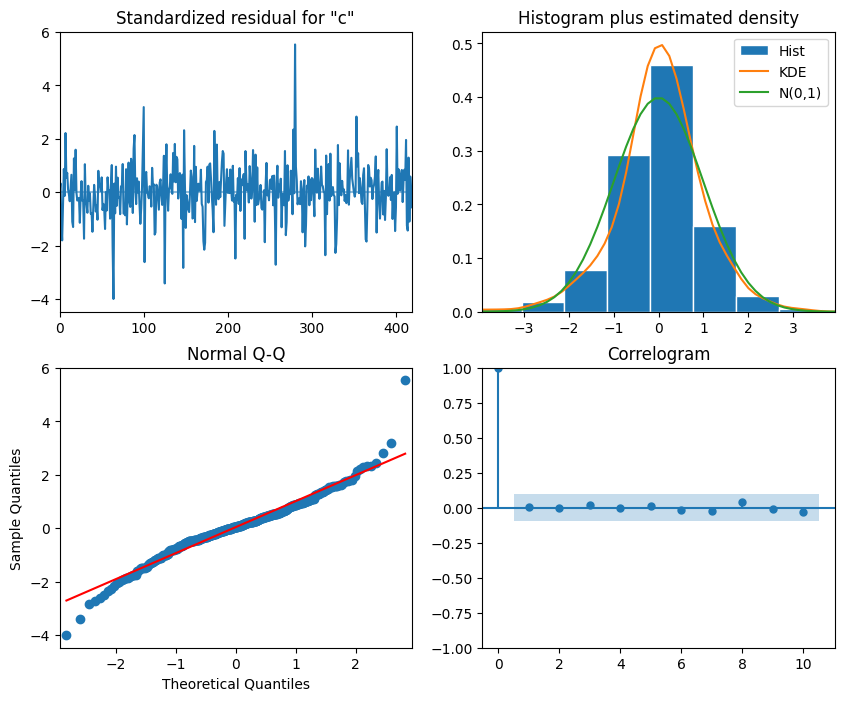

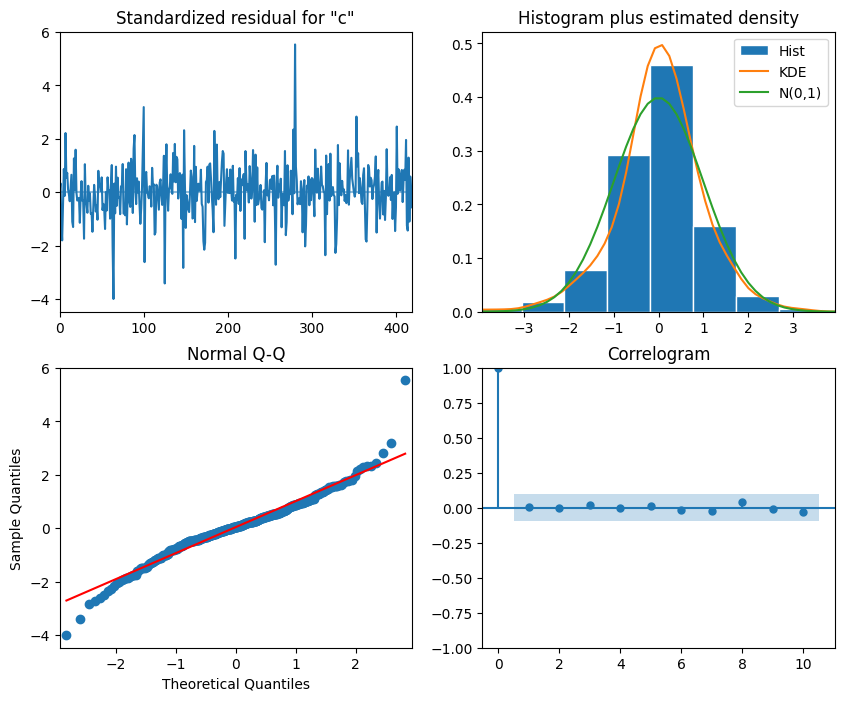

In [22]:
ARIMA_model_fit.plot_diagnostics(figsize=(10, 8)) # type: ignore
#plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/diagnostics.jpg', dpi=300)

リュング・ボックス検定

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid # type: ignore
result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,66.983694,2.737622e-16
2,66.984151,2.848239e-15
3,66.996985,1.875428e-14
4,66.998462,9.756147e-14
5,67.036479,4.234339e-13
6,67.048955,1.644724e-12
7,67.059451,5.791897e-12
8,67.078784,1.870388e-11
9,67.126773,5.555886e-11
10,67.127099,1.585112e-10


全てのp値が0.05より小さいので、残差に相関がある。つまり、ARIMA(9,2,12)でも表現できない。
強引に予測をしてみる。

In [22]:
ARIMA_pred = ARIMA_model_fit.get_prediction(422, 445).predicted_mean # type: ignore
test = data.iloc[-OFFSET:]
test["ARIMA_pred_2nd"] = ARIMA_pred

In [32]:
guideline = data.iloc[-2*OFFSET:]

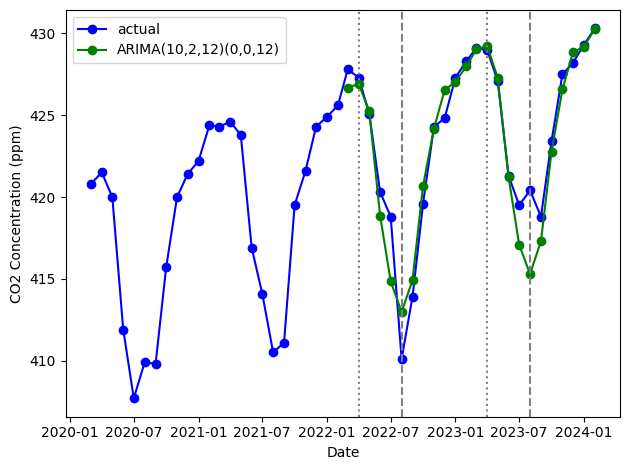

In [24]:
fig, ax = plt.subplots()


ax.plot(guideline['date'], guideline['co2'], 'b-', label='actual',marker='o')
ax.plot(test['date'], test['ARIMA_pred_2nd'], 'g-', label="ARIMA(10,2,12)(0,0,12)", marker='o')

aug_dates = test[test['date'].dt.month == 8]['date']
april_dates = test[test['date'].dt.month == 4]['date']

for aug_date in aug_dates:
    ax.axvline(x=aug_date, color='gray', linestyle='--')

for april_date in april_dates:
    ax.axvline(x=april_date, color='gray', linestyle=':')

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend(loc='best')
fig.autofmt_xdate
plt.tight_layout()
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/prediction.jpg', dpi=300)


### SARIMAモデルで予測する。
1階差分に対し、季節差分を取る。


In [24]:
df_diff_seasonal_diff_d_0 = np.diff(data['co2'], n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff_d_0)

criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: -24.12687265963685
p-value: 0.0
critical 1%: -3.446205926287236
critical 5%: -2.8685297226414734
critical 10%: -2.570493298011322


差分データは定常である。$(d,D,m)=(0,1,12)$とする。

In [26]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d = 0
D = 1
s = 12
SARIMA_order_list_d_0 = list(product(ps, qs, Ps, Qs))


In [27]:
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list_d_0, d, D, s)
SARIMA_result_df

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

,"(p,q,P,Q)",AIC
0,"(0, 0, 2, 3)",12.000000
1,"(1, 3, 2, 3)",20.000000
2,"(1, 2, 1, 1)",1289.389934
3,"(1, 2, 0, 2)",1290.082158
4,"(2, 2, 1, 1)",1290.161585
...,...,...
249,"(0, 0, 0, 3)",1769.982874
250,"(0, 0, 1, 0)",1797.481602
251,"(0, 0, 0, 2)",1813.115251
252,"(0, 0, 0, 1)",1858.021066


$(p,d,q)(P,D,Q,m)=(1,0,2)(1,1,1,12)$

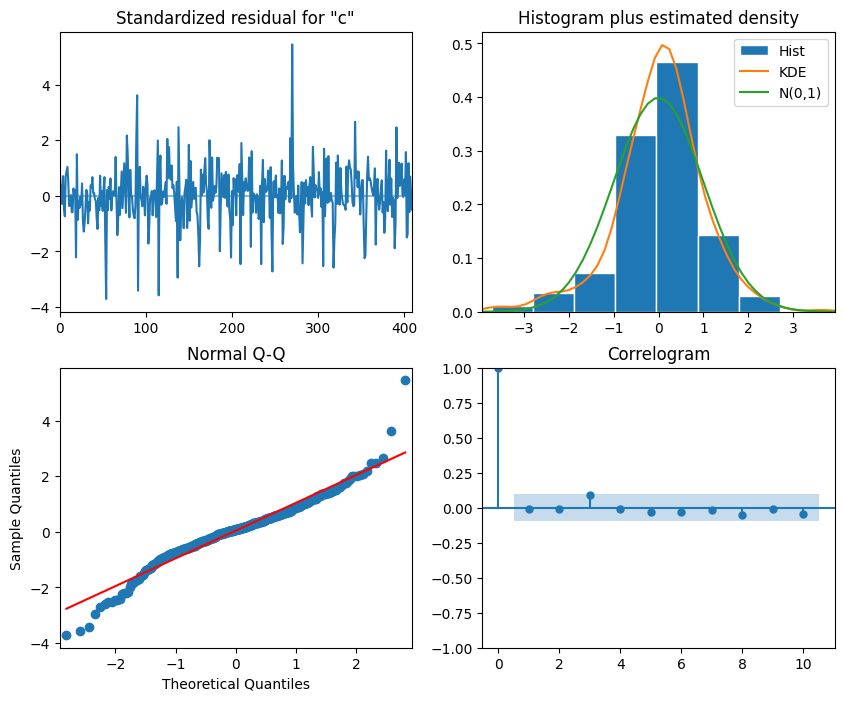

In [28]:
(p,d,q) = (1,0,2)
(P,D,Q,s) = (1,1,1,12)
SARIMA_model_d_0 = SARIMAX(train, order=(p, d, q), seasonal_order=(P,D,Q,s), simple_differencing=False)
SARIMA_model_fit_d_0 = SARIMA_model_d_0.fit(disp=False)
SARIMA_model_fit_d_0.plot_diagnostics(figsize=(10, 8)) # type: ignore
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/diagnostics.jpg', dpi=300)

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals_d_0 = SARIMA_model_fit_d_0.resid # type: ignore
result_df_d_0 = acorr_ljungbox(residuals_d_0, np.arange(1, 11, 1))
result_df_d_0

,lb_stat,lb_pvalue
1,356.353223,1.752549e-79
2,650.853619,4.665867e-142
3,889.552407,1.633662e-192
4,1078.547981,3.379838e-232
5,1223.869406,1.984361e-262
6,1331.488969,1.650950e-284
7,1406.946038,1.212372e-299
8,1455.679499,5.163692e-309
9,1483.424221,0.000000e+00
10,1495.905108,0.000000e+00


 残差が無相関でない。強引に予測してみる。

In [30]:
SARIMA_pred_d_0 = SARIMA_model_fit_d_0.get_prediction(422, 445).predicted_mean # type: ignore
test["SARIMA_pred_d_0"] = SARIMA_pred_d_0

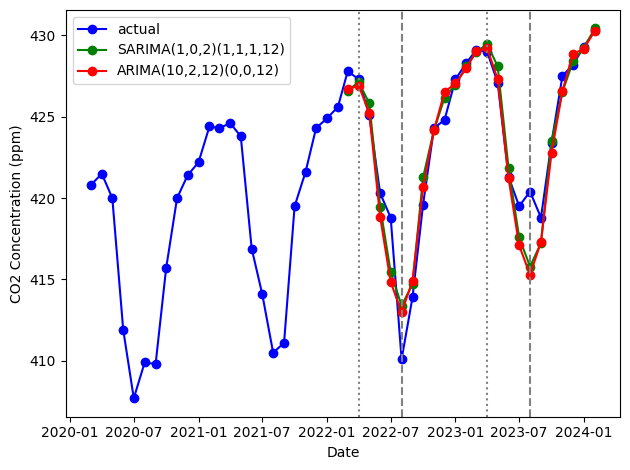

In [31]:
fig, ax = plt.subplots()


ax.plot(guideline['date'], guideline['co2'], 'b-', label='actual',marker='o')
ax.plot(test['date'], test['SARIMA_pred_d_0'], 'g-', label="SARIMA(1,0,2)(1,1,1,12)", marker='o')
ax.plot(test['date'], test['ARIMA_pred_2nd'], 'r-', label="ARIMA(10,2,12)(0,0,12)", marker='o')

aug_dates = test[test['date'].dt.month == 8]['date']
april_dates = test[test['date'].dt.month == 4]['date']

for aug_date in aug_dates:
    ax.axvline(x=aug_date, color='gray', linestyle='--')

for april_date in april_dates:
    ax.axvline(x=april_date, color='gray', linestyle=':')

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend(loc='best')
fig.autofmt_xdate
plt.tight_layout()
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/prediction_2.jpg', dpi=300)


次に、1次差分のあとに季節差分を取る。

In [32]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)

criticals = ad_fuller_result[4] # type:ignore
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f"critical 1%: {criticals['1%']}") # type:ignore
print(f"critical 5%: {criticals['5%']}") # type:ignore
print(f"critical 10%: {criticals['10%']}") # type:ignore

ADF Statistic: -27.695411542777787
p-value: 0.0
critical 1%: -3.4462444670071046
critical 5%: -2.8685466682709975
critical 10%: -2.5705023309762187


- ADF統計量は臨界値より小さい。
- p値は0.05より小さい。

よって、変換後のデータは定常であると言える。つまり、$d=1,D=1,s=12$として良い。次に、p,q,P,Qの値を探す。

In [33]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d = 1
D = 1
s = 12
SARIMA_order_list = list(product(ps, qs, Ps, Qs))


In [34]:
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kumada/projects/cct-seiya-kumada/sarima/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 1)",1280.757347
1,"(3, 1, 0, 2)",1281.495642
2,"(3, 1, 1, 2)",1282.441149
3,"(3, 1, 2, 1)",1282.507851
4,"(3, 2, 1, 1)",1282.560391
...,...,...
251,"(0, 0, 3, 0)",1473.676506
252,"(0, 0, 2, 0)",1484.376756
253,"(0, 0, 1, 0)",1508.646248
254,"(1, 0, 0, 0)",1517.521726


メモ：
- train=data['co2'][:-24]で21mかかった。警告たくさん出た。

$(p,q,P,Q)=(3,1,1,1),(d,D)=(1,1)$に決まった。

### 残差分析

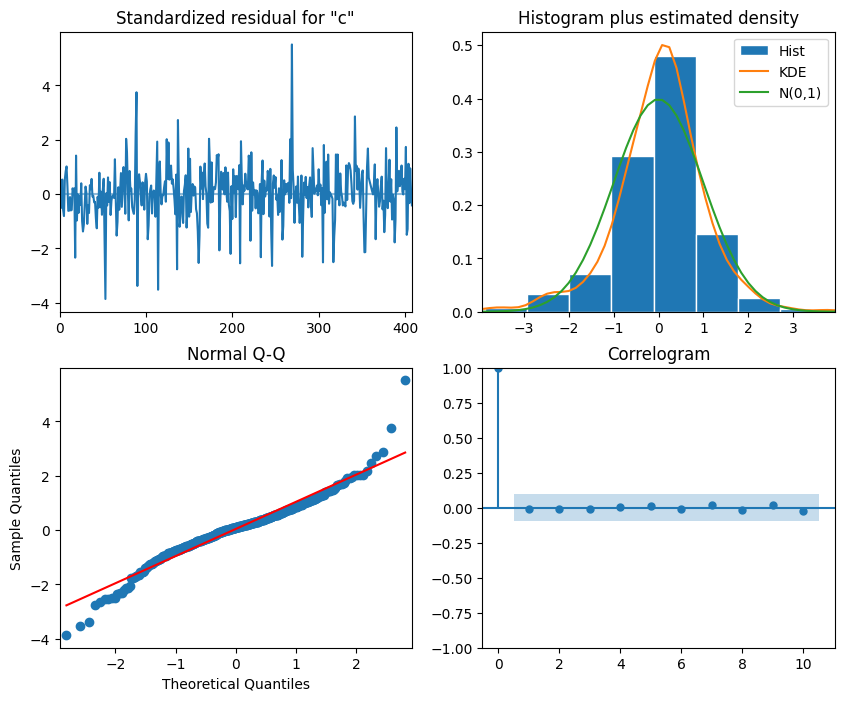

In [28]:
(p,d,q) = (3,1,1)
(P,D,Q,s) = (1,1,1,12)
SARIMA_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P,D,Q,s), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8)) # type: ignore
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/diagnostics.jpg', dpi=300)

- 左上図：振動の中心はゼロ近傍、振幅は全領域を通してほぼ同じ。つまり分散に変化がない。
- 右上図：残差分布は正規分布に従う。
- 左下図：Q-Qプロット。ほぼ直線。両端のずれは気になるけれど。
- 右下図：コレログラム。ラグ0の後に有意な自己相関係数がない。
以上の考察から、このモデルの残差はホワイトノイズに似ていると言える。

### リュング・ボックス検定

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid # type: ignore
result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,0.000072,0.993227
2,0.000319,0.999841
3,0.000681,0.999995
4,0.006874,0.999994
5,0.049850,0.999971
6,0.052688,0.999997
7,0.062256,1.000000
8,0.062466,1.000000
9,0.096008,1.000000
10,0.108761,1.000000


上の$p$値はすべて0.05を超えている。したがって、残差は無相関である。つまり、SARIMA(3,1,1)(1,1,1)_12で表現できる。

### 予測

In [30]:
SARIMA_pred = SARIMA_model_fit.get_prediction(422, 445).predicted_mean # type: ignore
test["SARIMA_pred"] = SARIMA_pred

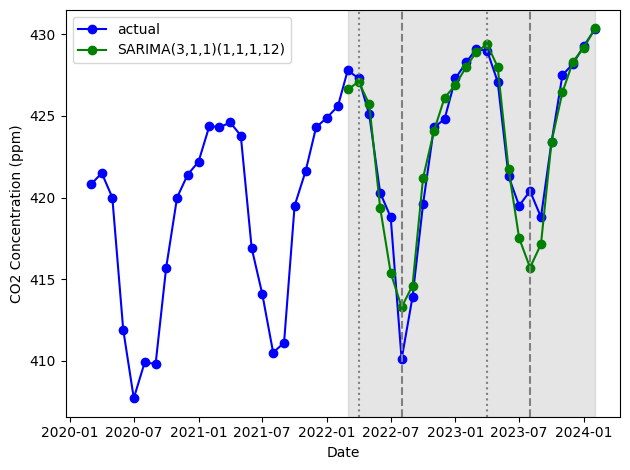

In [33]:
fig, ax = plt.subplots()


ax.plot(guideline['date'], guideline['co2'], 'b-', label='actual',marker='o')
ax.plot(test['date'], test['SARIMA_pred'], 'g-', label="SARIMA(3,1,1)(1,1,1,12)", marker='o')
#ax.plot(test['date'], test['SARIMA_pred_d_0'], 'g-', label="SARIMA(1,0,2)(1,1,1,12)", marker='o')
#ax.plot(test['date'], test['ARIMA_pred_2nd'], 'r-', label="ARIMA(10,2,12)(0,0,12)", marker='o')

aug_dates = test[test['date'].dt.month == 8]['date']
april_dates = test[test['date'].dt.month == 4]['date']

for aug_date in aug_dates:
    ax.axvline(x=aug_date, color='gray', linestyle='--')

for april_date in april_dates:
    ax.axvline(x=april_date, color='gray', linestyle=':')

ax.axvspan(test['date'].iloc[0], test['date'].iloc[-1], color='#808080', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend(loc='best')
fig.autofmt_xdate
plt.tight_layout()
plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/prediction_3.jpg', dpi=300)


- 垂直な点線：4月
- 垂直な破線：8月

In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
#mape_ARIMA = mape(test['co2'], test['ARIMA_pred_2nd'])
mape_SARIMA = mape(test['co2'], test['SARIMA_pred'])
#mape_SARIMA_d_0 = mape(test['co2'], test['SARIMA_pred_d_0'])

#print(mape_ARIMA, mape_SARIMA, mape_SARIMA_d_0)
print(mape_SARIMA)

0.25432273810544875


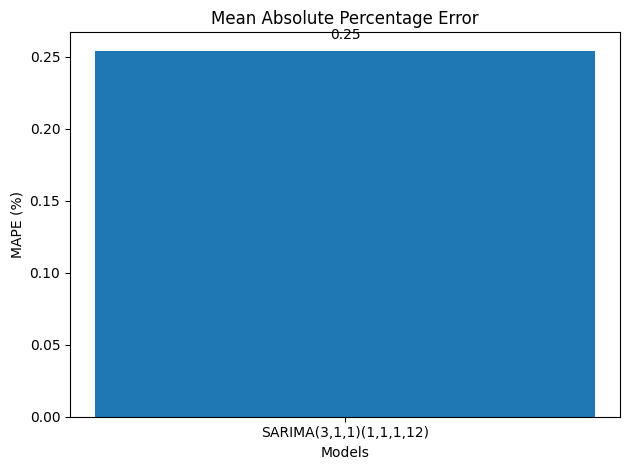

In [40]:
fig, ax = plt.subplots()

#x = ['ARIMA(10,2,12)', 'SARIMA(1,0,2)(1,1,1,12)', 'SARIMA(3,1,1)(1,1,1,12)']
#y = [mape_ARIMA, mape_SARIMA_d_0, mape_SARIMA]

x = ['SARIMA(3,1,1)(1,1,1,12)']
y = [mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 15)
ax.set_title('Mean Absolute Percentage Error')
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.008, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('/home/kumada/projects/cct-seiya-kumada/sarima/images/mapes.jpg', dpi=300)
#plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)

|モデル名|リュング・ボックス検定|
|----|----|
|ARIMA(p=6,d=1,q=5)|残差に相関あり|
|ARIMA(p=10,d=2,q=12)|残差に相関あり|
|SARIMA(p=1,d=0,q=2)(P=1,D=1,Q=1,m=12)|残差に相関あり|
|SARIMA(p=3,d=1,q=1)(P=1,D=1,Q=1,m=12)|残差に相関なし|


In [42]:
guideline

,date,co2
398,2020-03-01,420.8
399,2020-04-01,421.5
400,2020-05-01,420.0
401,2020-06-01,411.9
402,2020-07-01,407.7
403,2020-08-01,409.9
404,2020-09-01,409.8
405,2020-10-01,415.7
406,2020-11-01,420.0
407,2020-12-01,421.4


In [62]:
print(test['date'].iloc[0])
print(test['date'].iloc[-1])

2022-03-01 00:00:00
2024-02-01 00:00:00
